<p align="center"><strong>Content-Based Filtering</strong></p>

# Data Loading

**Detail Atribut:**

**Anime.csv**

- anime_id - id unik anime dari myanimelist.net's
- name - judul anime
- genre - genre dari anime, dipisahkan dengan koma.
- type - tipe anime berupa movie (film), TV, OVA (original animation video), ONA (Original Net Animations), Music (musik), dan Special (spesial).
- episodes - berapa banyak episode (1 jika movie).
- rating - rata-rata nilai rating anime dari 10.
- members - jumlah member dari komunitas anime tersebut.

**Rating.csv**

- user_id - id pengguna yang dihasilkan secara acak dan tidak dapat diidentifikasi.
- anime_id - id anime yang sudah dirating user.
- rating - rating yang diberikan user dari 10 (bernilai -1 jika user sudah menonton anime tetapi tidak memberikan rating).

Sebelum import dataset melalui Kaggle, pastikan sudah mendownload kaggle.json (berupa Kaggle API token).
- Buat sebuah direktori bernama .kaggle
- Copy kaggle.json ke direktori
- Lakukan permission terhadap file
- download dataset
- jika dataset berupa file zip maka unzip terlebih dahulu

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download CooperUnion/anime-recommendations-database

 80% 20.0M/25.0M [00:00<00:00, 86.6MB/s]
100% 25.0M/25.0M [00:00<00:00, 89.5MB/s]


In [4]:
! unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


Import libraries yang dibutuhkan

In [117]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Read data `anime.csv` dan `rating.csv`

In [118]:
df_anime = pd.read_csv('/content/anime.csv')
df_rating = pd.read_csv('/content/rating.csv')

In [119]:
df_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [120]:
df_rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Ukuran df_anime sebesar (12294, 7) dan df_rating sebesar (7813737, 3)

In [121]:
print(df_anime.shape)
print(df_rating.shape)

(12294, 7)
(7813737, 3)


# Univariate EDA

## df_anime

Periksa informasi mengenai feature-feature yang ada di df_anime.

In [122]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [123]:
df_anime['name']

0                                           Kimi no Na wa.
1                         Fullmetal Alchemist: Brotherhood
2                                                 Gintama°
3                                              Steins;Gate
4                                            Gintama&#039;
                               ...                        
12289         Toushindai My Lover: Minami tai Mecha-Minami
12290                                          Under World
12291                       Violence Gekiga David no Hoshi
12292    Violence Gekiga Shin David no Hoshi: Inma Dens...
12293                     Yasuji no Pornorama: Yacchimae!!
Name: name, Length: 12294, dtype: object

Jumlah setiap genre di anime

In [124]:
df_anime['genre'].value_counts()

Hentai                                                  823
Comedy                                                  523
Music                                                   301
Kids                                                    199
Comedy, Slice of Life                                   179
                                                       ... 
Adventure, Drama, Fantasy, Game, Sci-Fi                   1
Adventure, Demons, Fantasy, Historical                    1
Action, Comedy, Drama, Mecha, Music, Sci-Fi, Shounen      1
Action, Comedy, Fantasy, Mecha, Sci-Fi, Shounen           1
Hentai, Slice of Life                                     1
Name: genre, Length: 3264, dtype: int64

(-0.5, 799.5, 399.5, -0.5)

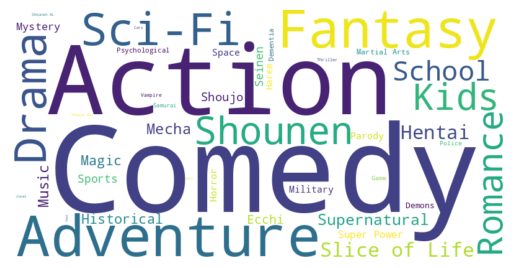

In [125]:
#karena setiap kategori dipisahkan dengan koma, maka split kemudian count genrenya
test = df_anime['genre'].str.split(', ')
count = test.explode().value_counts()

genres_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(count)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

Jumlah setiap tipe di anime

In [126]:
df_anime['type'].value_counts()

TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: type, dtype: int64

Tidak ada duplikasi untuk id anime

In [127]:
df_anime['anime_id'].duplicated().sum()

0

Terdapat duplikasi pada nama anime, hanya saja setelah diperiksa nama dan id anime berbeda, sehingga tidak dilakukan drop.

In [128]:
duplikat = df_anime[df_anime['name'].duplicated()]
duplikat

,anime_id,name,genre,type,episodes,rating,members
10141,30059,Saru Kani Gassen,Drama,Movie,1,4.75,76
10194,33195,Shi Wan Ge Leng Xiaohua,"Action, Adventure, Comedy, Fantasy, Parody",Movie,1,7.07,110


## df_rating

Untuk periksa informasi yang ada di df_rating.

In [129]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [130]:
print("Jumlah ID anime di df_anime: ",df_anime['anime_id'].nunique())
print("Jumlah ID anime di df_rating: ",df_rating['anime_id'].nunique())
print("Jumlah ID user: ",df_rating['user_id'].nunique())
print("Jumlah nama anime: ",df_anime['name'].nunique())

Jumlah ID anime di df_anime:  12294
Jumlah ID anime di df_rating:  11200
Jumlah ID user:  73515
Jumlah nama anime:  12292


Sebagai contoh user_id = 2 telah menonton ketiga anime dengan id 11771, 12189, dan 16417. User ini telah menilai anime 11771 dengan nilai 10/10. Sedangkan user ini belum rate kedua anime lainnya yang ditonton, maka nilainya -1.

In [131]:
df_rating[df_rating['user_id'] == 2]

,user_id,anime_id,rating
153,2,11771,10
154,2,12189,-1
155,2,16417,-1


# Data Pre-Processing

Rename jadi `rating_user` pada df_rating agar tidak memiliki nama kolom yang sama saat merge dengan df_anime.

In [132]:
df_rating = df_rating.rename(columns={"rating":"rating_user"})

Menggabungkan df_anime dengan df_rating dan memasukkannya ke dalam variabel all_anime_df.


In [133]:
all_anime_df = pd.merge(df_anime, df_rating, on='anime_id', how='left')
all_anime_df

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278.0,-1.0
...,...,...,...,...,...,...,...,...,...
7814819,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,39532.0,-1.0
7814820,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,48766.0,-1.0
7814821,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365.0,4.0
7814822,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,27364.0,-1.0


Setelah digabungkan, jumlahnya menjadi (7814824, 9)

In [134]:
all_anime_df.shape

(7814824, 9)

# Data Preparation

Untuk periksa informasi gabungan hasil kedua dataframe.

In [135]:
all_anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7814824 entries, 0 to 7814823
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     object 
 5   rating       float64
 6   members      int64  
 7   user_id      float64
 8   rating_user  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 596.2+ MB


Untuk user yang tidak rating atau -1 diberikan nilai NaN, karena hal ini sama saja dengan user yang tidak memberikan nilai rating sama sekali atau bernilai 0.

Kemudian rating_user yang bernilai NaN akan didrop.

In [136]:
all_anime_df["rating_user"].replace({-1.0: np.nan}, inplace=True)
all_anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152.0,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244.0,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271.0,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278.0,NaN


In [137]:
all_anime_df[all_anime_df['rating_user']== -1]

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user


Periksa kembali apakah terdapat nilai kosong yang lain.

In [138]:
all_anime_df.isnull().sum()

anime_id             0
name                 0
genre              140
type                28
episodes             0
rating             233
members              0
user_id           1097
rating_user    1477585
dtype: int64

Drop semua nilai yang bernilai null

In [139]:
all_anime_df.dropna(axis=0, how='any', inplace=True)
all_anime_df.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
rating_user    0
dtype: int64

Drop kolom yang duplikasi terutama pada anime_id dan name. Drop tersebut dilakukan untuk melakukan sistem rekomendasi pada nama anime dengan genrenya, sehingga tidak boleh duplikat.

In [140]:
all_anime_df = all_anime_df.drop_duplicates(subset=['anime_id', 'name'], keep='first')

In [141]:
all_anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99.0,5.0
2199,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,3.0,10.0
26774,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,43.0,10.0
28159,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,5.0,9.0
47442,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,5.0,9.0


Agar mudah dibaca dan dipahami oleh mesin, feature name dan genre akan dilakukan cleaning jika memiliki nilai &quot, .hack//, &#039;, A&#039;s, I&#039;, dan &amp; menggunakan library regex.

In [142]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)

    return text

all_anime_df['name'] = all_anime_df['name'].apply(text_cleaning)
all_anime_df['genre'] = all_anime_df['genre'].apply(text_cleaning)

<ipython-input-142-4a7a9534a180>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_anime_df['name'] = all_anime_df['name'].apply(text_cleaning)
<ipython-input-142-4a7a9534a180>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_anime_df['genre'] = all_anime_df['genre'].apply(text_cleaning)


Ukuran dataframe berubah menjadi (9892, 9) setelah drop kolom yang duplikat




In [143]:
all_anime_df.shape

(9892, 9)

# Modelling

## TF-IDF

Sebelum masuk ke tahap modelling, data akan dilakukan TF-IDF terlebih dahulu untuk menemukan representasi fitur penting dari setiap genre anime.

In [144]:
tf = TfidfVectorizer()

tf.fit(all_anime_df['genre'])

tf.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire', 'yaoi', 'yuri'],
      dtype=object)

Lakukan fit dan transformasi ke dalam bentuk matriks. Hasilnya berupa 9892 nama anime dengan 47 genre.

In [145]:
tfidf_matrix = tf.fit_transform(all_anime_df['genre'])

tfidf_matrix.shape

(9892, 47)

Untuk menghasilkan vektor TF-IDF dalam bentuk matriks, gunakan fungsi `todense()`

In [146]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29047501, 0.32071235, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.24385925, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Dataframe dibawah dibuat untuk melihat matriks tf-idf untuk beberapa anime dan genrenya.

In [147]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=all_anime_df.name
).sample(22, axis=1).sample(10, axis=0)

,historical,harem,yaoi,game,seinen,josei,arts,kids,drama,cars,...,supernatural,mecha,ecchi,power,military,ai,fantasy,police,comedy,thriller
name,,,,,,,,,,,,,,,,,,,,,
Hidamari Sketch: Chou Hidamatsuri Special,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.0
Stay the Same,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.698331,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
Chiisana Kyojin Microman,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.356418,0.0,0.0,...,0.0,0.347417,0.0,0.423596,0.0,0.0,0.000000,0.0,0.198326,0.0
Arakawa Under the Bridge,0.0,0.0,0.0,0.0,0.748834,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.365270,0.0
Yuureisen,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
Kyoto Animation: Ikitaku Naru Omise-hen,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
Dracula no Uta,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.466043,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
Dragon Ball: Episode of Bardock,0.0,0.0,0.0,0.0,0.000000,0.0,0.424215,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.373052,0.0,0.0,0.237966,0.0,0.174662,0.0
Fairy Forest Remi-chan,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0


## Cosine-Similarity

Sekarang, hitung similarity degree antar anime dengan teknik Cosine-Similarity.

In [148]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.15439041, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15439041, 1.        , 0.17128271, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17128271, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

Teknik ini digunakan untuk identifikasi kesamaan antara satu anime dengan anime lainnya.

In [149]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=all_anime_df['name'], columns=all_anime_df['name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9892, 9892)


name,Daimajuu Gekitou: Hagane no Oni,Gakkou no Kowai Uwasa Shin: Hanako-san ga Kita!!,Lupin III: Pilot Film,Neko nanka Yondemo Konai.,Oshiete! Galko-chan
name,,,,,
Tentai Senshi Sunred,0.000000,0.066483,0.106839,0.267332,0.064934
Yami no Shihosha Judge,0.421217,0.670144,0.000000,0.336493,0.000000
Samuraider: Nazo no Tenkousei,0.000000,0.000000,0.207327,0.000000,0.000000
Toushindai My Lover: Minami tai Mecha-Minami,0.000000,0.000000,0.000000,0.000000,0.000000
Heartcatch Precure!,0.000000,0.225405,0.241647,0.501526,0.732137
Slayers: The Motion Picture,0.000000,0.091542,0.451505,0.000000,0.089409
Kodomo no Keijijougaku,0.000000,0.000000,0.000000,0.000000,0.000000
Nezumi Monogatari: George to Gerald no Bouken,0.000000,0.000000,0.000000,0.000000,0.000000
Hello Kitty no Kurumi Wari Ningyou,0.000000,0.000000,0.000000,0.000000,0.000000


Buatlah sebuah fungsi `anime_recommendations` dengan parameter:
- anime_name: nama anime
- similarity_data: fungsi cosine-similarity
- items: name dan genre

Keluaran sistem rekomendasi berupa top-N recommendation.


Beberapa penjelasan method dan variable yang digunakan:
- argpartition: mengambil sejumlah nilai k tertinggi dari similarity function
- kemudian, ambil data dari bobot tertinggi ke rendah dan masukkan data ini ke variable closest
- dalam hal ini kita ingin cari rekomendasi dari anime berjudul Persona 5 the Animation: The Day Breakers, sehingga drop anime dengan judul ini agar tidak muncul dalam daftar rekomendasi (tidak double)

In [150]:
def anime_recommendations(anime_name, similarity_data=cosine_sim_df, items=all_anime_df[['name', 'genre']], k=5):
    index = similarity_data.loc[:,anime_name].to_numpy().argpartition(
        range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(anime_name, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [159]:
all_anime_df[all_anime_df['name'].eq('Tentai Senshi Sunred')]

,anime_id,name,genre,type,episodes,rating,members,user_id,rating_user
2534474,5005,Tentai Senshi Sunred,"Comedy, Parody, Seinen, Super Power",TV,26,7.96,12236,269.0,7.0


In [160]:
anime_recommendations('Tentai Senshi Sunred')

,name,genre
0,Tentai Senshi Sunred 2nd Season,"Comedy, Parody, Seinen, Super Power"
1,Tentai Senshi Sunred: Short Corner,"Comedy, Parody, Seinen, Super Power"
2,Kawasaki Frontale x Tentai Senshi Sunred,"Comedy, Parody, Seinen, Sports, Super Power"
3,Kawasaki Frontale x Tentai Senshi Sunred 2nd S...,"Comedy, Parody, Seinen, Sports, Super Power"
4,Himitsukessha Taka no Tsume,"Comedy, Parody, Super Power"


# Model Evaluation

(Perhitungan manual)

Metrik yang digunakan pada model ini adalah Precision score. Precision score pada sistem rekomendasi memiliki rumus n rekomendasi yang relevan / n item yang direkomendasikan. Detailnya sebagai berikut:

![Precision](https://latex.codecogs.com/svg.latex?%5Cdpi%7B300%7D%20%5Csmall%20%5Cbg_white%20%5Cfn_cm%20P%20%3D%20%5Cfrac%7B%5Ctext%7Bour%20recommendations%20that%20are%20relevant%7D%7D%7B%5Ctext%7Bitems%20we%20recommended%7D%7D)

Sebagai contoh `anime_recommendations('Tentai Senshi Sunred')` memberikan rekomendasi seperti di atas.

Genre pada anime Tentai Senshi Sunred adalah Comedy, Parody, Seinen, Super Power. Maka dari 5 item yang direkomendasikan, anime dari nomor 0-3 memiliki kategori yang persis sama dengan anime Tentai. Artinya nilai Precision sebesar:

P = 4/5 = 0.8 = 80%

Jadi, nilai precision score pada anime Tentai Senshi Sunred adalah **80%**.




---



